In [26]:
%%HTML 
<!--
    EXECUTE THIS CELL TO FORMAT THE NOTEBOOK
-->
<style> 
    
    body.jp-Notebook { max-width: 700pt; margin-left: auto; margin-right: auto; border-left: 1pt solid gray; border-right: 1pt solid gray; }          
    h1 { margin-top: 60pt!IMPORTANT; }
    h2 { margin-top: 60pt!IMPORTANT; }
    h3 { margin-top: 30pt!IMPORTANT; }
    h4 { margin-top: 20pt!IMPORTANT; }
</style>

<script>
    
    function luc7213_toggle( link ) {
        var cell = link.luc7213_cell;
        if( cell.style.visibility != 'hidden' ) {
            cell.style.visibility = 'hidden';
            cell.style.position = 'absolute';
            link.innerHTML = link.innerHTML = "[show "+link.luc7213_cell_type+"]";
        }
        else {
            cell.style.visibility = 'visible';
            cell.style.position = '';
            link.innerHTML = link.innerHTML = "[hide "+link.luc7213_cell_type+"]";
        }        
    }
    
    function luc7213_enhance( cell ) {        
        var tags = cell.className.split( " " );   
        var tags2 = cell.querySelectorAll('.cell-tag');
        for( const el of tags2 ) { tags[tags.length] = el.innerText; }
    
        var div = cell.querySelector(".luc7213" );
        if( !div ) {            
            console.debug( 'found new cell' );
            div = document.createElement('DIV');
            div.style.textAlign = 'right';            
            div.className = 'luc7213';
            cell.insertBefore( div, cell.firstChild );        
        }
        
        var code = cell.querySelector('.input_area, .jp-Cell-inputWrapper' );                    
        var codeLink = div.querySelector( '.luc7123_code' );
        if( !codeLink ) {
            console.debug( 'add show/hide link for code' );
            codeLink = document.createElement('A');
            div.appendChild( codeLink );
            codeLink.className = 'luc7123_code';
            codeLink.innerHTML = '[hide code]';
            codeLink.setAttribute( 'onclick', "luc7213_toggle(this); return false;" );
            codeLink.luc7213_cell = code;
            codeLink.luc7213_cell_type = "code";
            if( !tags.includes( 'showcode' ) && !tags.includes( 'celltag_showcode' ) ) {
                luc7213_toggle(codeLink);
            }
        }   
        
        var output = cell.querySelector('.output_area, .jp-OutputArea' );                            
        if( output ) {
            var outLink = div.querySelector('.luc7123_output');
            if( !outLink ) {
                console.debug( 'add show/hide link for output' );
                outLink = document.createElement('A');
                div.appendChild( outLink );
                outLink.className = 'luc7123_output';
                outLink.innerHTML = '[hide output]';
                outLink.setAttribute( 'onclick', 'luc7213_toggle(this); return false;' );
                outLink.luc7213_cell = output;
                outLink.luc7213_cell_type = "output";
                if( tags.includes( 'hideoutput' ) || tags.includes( 'celltag_hideoutput' )) {
                    luc7213_toggle(outLink);
                }

            }
        }
    }
    
    var luc7213_started = false;
    
    function luc7213_main() {   
        if( !luc7213_started ) {
            var s = document.querySelector( '#site' );
            if( s ) s.scrollTo(0,0);
            luc7213_started=true;
        }
        
        var lsCells = document.querySelectorAll('.jp-CodeCell, .code_cell' );
        for( var i = 0; i < lsCells.length; i++ ) {
            var cell = lsCells[i];
            luc7213_enhance( cell );
        }    
        var lsTitles = document.querySelectorAll( 'h2, h3, h4' );
        var counter = [0,0,0]
        for( var i = 0; i < lsTitles.length; i++ ) {
            var title = lsTitles[i];
            var number = title.querySelector('.luc7213');
            if( !number ) {
                number = document.createElement('SPAN');
                title.insertBefore( number, title.firstChild );
                number.className='luc7213';                
            }            
            if( title.tagName == 'H2') { 
                counter[0]++; counter[1]=0; counter[2]=0; 
                number.innerHTML = counter[0] + ". ";
            }
            if( title.tagName == 'H3') { 
                counter[1]++; counter[2]=0; 
                number.innerHTML = counter[0] + "." + counter[1] + ". ";
            }
            if( title.tagName == 'H4') { 
                counter[2]++; 
                number.innerHTML = counter[0] + "." + counter[1] + "." + counter[2];
            }
        }        
        
        setTimeout( luc7213_main, 1000 )
    }
    
    luc7213_main()
    
</script>


                                   Autor: Lucas de Sousa Brito
                                   Junho de 2021

# Estudos em uma base pública de fraudes de cartão de crédito

## Resumo

Neste notebook foi efetuado o treinamento de uma rede neural para identificação de fraude em uma base pública de fraudes de cartões de crédito na qual foi possível identificar 71% das transações fraudulentas do conjunto de testes com 91% de acerto em relação as transações alertadas.

## Preparação

### Carrega as bibliotecas principais...

A instalação do tensorflow para GPU é meio complicada pois a lista de bibliotecas existentes no sítio do tensorflow não estão corretas. O melhor caminho que encontrei foi fazer o `import tensorflow as tf` em um ipython (propmt do python) pois a mensagem das bibliotecas faltantes aparece na console e assim eu posso ir fazendo o apt-get para a biblioteca específica.

No código abaixo também estão comentados os comandos para instalação do tensorflow no linux. 

**resultado da importação**

In [23]:
#start_hidden

print( 'Carregando bibliotecas principais...')

import sys
#!{sys.executable} -m pip uninstall -y tensorflow
#!{sys.executable} -m pip install tensorflow==2.5.0

import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools


print( 'Carregando bibliotecas principais... ok')

#strategy = tf.distribute.MirroredStrategy() 
#print( "Placas aceleradoras a disposição: ", strategy.num_replicas_in_sync)


Carregando bibliotecas principais...
Carregando bibliotecas principais... ok


## Carga dos dados

Os dados de origem estão disponíveis em https://www.kaggle.com/mlg-ulb/creditcardfraud e suportamente correspondem a uma base com dados reais de movimento de uma instituição financeira europeia em 2013 anonimizados. Esse é um conjunto de dados bem popular na ciência de dados, mas não há muita informação sobre sua origem e não há como validar que se tratam de dados reais. 

Foram efetuados pré-processamentos:
* foi adicionado atributos de data e hora em formato mais humano para facilitar o entendimento dos dados
* foram adicionadas atributos de valor por faixa

In [27]:
#start_hidden

def bloco():

    import pandas as pd
    import sklearn
    
    global df
    global df_len

    print( 'Carrega o arquivo de dados...' )
    df = pd.read_csv('data/creditcard.csv')

    df_len = len(df)
    
    print( 'Ajusta alguns atributos...' )
    df = df.rename(columns={'Time':'dt'})
    df = df.rename(columns={'Amount':'vr'})

    df.insert( 1, 'dt_hora', df['dt'].apply( lambda x: int(x%(24*60*60)/(60*60) ) ) )
    df.insert( 2, 'dt_wday', ( df['dt'].apply( lambda x: int(x/(24*60*60)%7) ) ) ) 
    df['dt'] = df['dt'].apply( lambda x: int(x/(24*60*60)) )
    df = df.rename(columns={'dt':'dt_dia'})
        
    df['vr1'] = df['vr'].apply( lambda x: 1 if x < 10 else 0 )
    df['vr2'] = df['vr'].apply( lambda x: 1 if 10 < x < 20 else 0 )
    df['vr3'] = df['vr'].apply( lambda x: 1 if 20 < x < 50 else 0 )
    df['vr4'] = df['vr'].apply( lambda x: 1 if 50 < x < 100 else 0 )
    df['vr5'] = df['vr'].apply( lambda x: 1 if 100 < x < 200 else 0 )
    df['vr6'] = df['vr'].apply( lambda x: 1 if 200 < x < 500 else 0 )
    df['vr7'] = df['vr'].apply( lambda x: 1 if 500 < x < 1000 else 0 )
    df['vr8'] = df['vr'].apply( lambda x: 1 if 1000 < x < 1500 else 0 )
    df['vr9'] = df['vr'].apply( lambda x: 1 if 1500 < x < 2000 else 0 )
    df['vr10'] = df['vr'].apply( lambda x: 1 if 2000 < x < 2500 else 0 )
    df['vr11'] = df['vr'].apply( lambda x: 1 if 2500 < x < 5000 else 0 )
    df['vr12'] = df['vr'].apply( lambda x: 1 if 5000 < x else 0 )

    assert df_len==len(df), "Ooops, o tamanho do conjunto de entrada (df) foi alterado"
    print( 'OK' )        
    
bloco()

Carrega o arquivo de dados...
Ajusta alguns atributos...
OK


### Visão geral dos dados

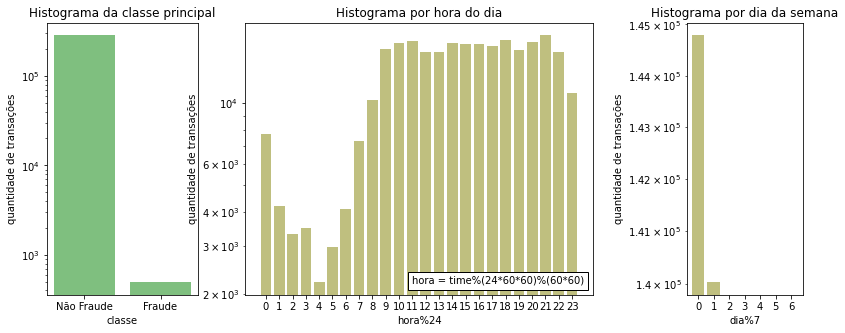

In [28]:
#start_hidden
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def bloco():

    fig = plt.figure(figsize=(15,5))
    fig_grid = fig.add_gridspec(100,360)

    ax = fig.add_subplot( fig_grid[ 0:100, 15:80 ] )
    ax.set( title="Histograma da classe principal", 
            xlabel="classe", xticks=[0,1], xticklabels=['Não Fraude', 'Fraude'],
            ylabel="quantidade de transações",  yscale="log" )
    ax.hist( df['Class'] , [x for i in range(2) for x in (i-0.4,i+0.4)], color='#00800080')

    ax_cols = [x for x in range(0,24)]
    ax = fig.add_subplot( fig_grid[ 0:100, 100:250 ] )
    ax.set( title="Histograma por hora do dia",
            xlabel='hora%24', xticks=ax_cols, xticklabels=ax_cols, 
            ylabel='quantidade de transações', yscale='log' )
    ax.hist( df['dt_hora'] , [x for i in ax_cols for x in (i-0.4,i+0.4)], color='#80800080')
    ax.add_artist(matplotlib.offsetbox.AnchoredText("hora = time%(24*60*60)%(60*60)", frameon=True, loc='lower right'))

    ax_cols = [x for x in range(0,7)]
    ax = fig.add_subplot( fig_grid[ 0:100, 290:340 ] )
    ax.set( title="Histograma por dia da semana",
            xlabel='dia%7', xticks=ax_cols, xticklabels=ax_cols,
            ylabel='quantidade de transações', yscale='log')
    ax.hist( df['dt_wday'] , [x for i in ax_cols for x in (i-0.4,i+0.4)], color='#80800080')

    plt.show()

bloco()

In [29]:
#start_hidden
def bloco():
    
    u = df.describe().transpose()
    
    u['Tipos'] = df.dtypes
    u['Val.Distintos'] = df.nunique()    
    u['%distintos'] = df.nunique() / len(df) * 100.0
    
    return u.transpose()

bloco()

,dt_dia,dt_hora,dt_wday,V1,V2,V3,V4,V5,V6,V7,...,vr3,vr4,vr5,vr6,vr7,vr8,vr9,vr10,vr11,vr12
count,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,...,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0
mean,0.491635,14.04647,0.491635,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,...,0.177573,0.127725,0.095479,0.067923,0.021323,0.005583,0.002258,0.000797,0.001352,0.000193
std,0.499931,5.835854,0.499931,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,...,0.382153,0.333784,0.293876,0.251614,0.14446,0.074509,0.047461,0.028221,0.036742,0.013895
min,0.0,0.0,0.0,-56.40751,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,10.0,0.0,-0.920373,-0.59855,-0.890365,-0.84864,-0.691597,-0.768296,-0.554076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,15.0,0.0,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,19.0,1.0,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,23.0,1.0,2.45493,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Tipos,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
Val.Distintos,2,24,2,275663,275663,275663,275663,275663,275663,275663,...,2,2,2,2,2,2,2,2,2,2


### Padroniza e gera os conjuntos de treino, validação e teste

Foram criados os seguintes conjuntos de dados
* X_train / y_train com 64% dos dados. Este conjunto será usado para o treinamento do modelo.
* X_validation / y_validation com 16% dos dados. Este conjunto será usado para a validação do modelo.
* X_test / y_test com 20% dos dados. Este conjunto será usado para o teste final do modelo.

Como o conjunto de dados é muito desbalanceado, os dados da classe 1 (fraude) foi duplicado no conjunto de dados de treinamento para garantir um bom treinamento da rede neural.

In [31]:
#start_hidden
def bloco():
    
    global X_train, X_test, X_validation
    global y_train, y_test, y_validation    
    
    from sklearn.model_selection import train_test_split
    
    # separa conjunto de treinamento e testes
    X_train, X_test = train_test_split(df, test_size=0.2, stratify=df['Class'])
    
    # separa conjunto de validação
    X_train, X_validation = train_test_split(X_train, test_size=0.2, stratify=X_train['Class'])
   
    # balanceia as amostras    
    X_train_fraude = X_train[ X_train['Class'] == 1 ]
    X_train_naofraude = X_train[ X_train['Class'] == 0 ]
    
    for i in range( int( len(X_train_naofraude)/len(X_train_fraude) ) ):
        X_train = X_train.append( X_train_fraude )
    
    X_train = X_train.sample(frac=1).reset_index(drop=True)    
       
    # separa y das amostras
    y_train = X_train.pop( 'Class' )
    y_test = X_test.pop( 'Class' )
    y_validation = X_validation.pop( 'Class')
        
    print(f'Training shape: {X_train.shape} {y_train.shape}' )
    print(f'Validation shape: {X_validation.shape} {y_validation.shape}' )
    print(f'Test shape: {X_test.shape} {y_test.shape}' )
         
bloco()

Training shape: (364146, 44) (364146,)
Validation shape: (91037, 44) (91037,)
Test shape: (56962, 44) (56962,)


## Cria o modelo

Monta um modelo simples de rede neural multicamada para a predição dos valores. 

### Estrutura e compila

In [85]:
#start_hidden

def bloco():

    global model
    
    model = tf.keras.models.Sequential([    
        tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),        
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(64,activation='relu'), 
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.summary()
    
    METRICS = [
      tf.keras.metrics.TruePositives(name='positivo_correto',thresholds=0.5),
      tf.keras.metrics.FalsePositives(name='positivo_incorreto',thresholds=0.5),
      tf.keras.metrics.TrueNegatives(name='negativo_correto',thresholds=0.5),
      tf.keras.metrics.FalseNegatives(name='negativo_incorreto',thresholds=0.5), 
      tf.keras.metrics.BinaryAccuracy(name='acc',threshold=0.5),
      tf.keras.metrics.Precision(name='precision',thresholds=0.5),
      tf.keras.metrics.Recall(name='recall',thresholds=0.5),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(
            learning_rate=0.0001, 
            decay=1e-05
        ),    
        
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS
    )
    
    print( 'OK, modelo compilado...' )
       
bloco()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_39 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 64)                2880      
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 65        
Total params: 7,105
Trainable params: 7,105
Non-trainable params: 0
___________________________________________________

### Treinamento

O histórico abaixo corresponde ao log de execução do modelo.

In [86]:
#start_hidden
def bloco():
    global history
        
    mp_epochs=3
    mp_batch_size = 20

    my_callbacks = [
        # abandona o processamento se a acurácia não melhorar em até {patitence} épocas
        tf.keras.callbacks.EarlyStopping(monitor='val_acc',patience=4), 
        # grava os modelos intermediários
        tf.keras.callbacks.ModelCheckpoint(filepath='model/modelo001.{epoch:02d}.h5'), # salva o modelo para poder retomar o treinamento
        # grava informações para visualização
        tf.keras.callbacks.TensorBoard(log_dir='./logs'), 
    ]

    history = model.fit(
        X_train, 
        y_train, 
        batch_size=mp_batch_size,
        epochs=mp_epochs,
        callbacks=my_callbacks,
        validation_data=(X_validation,y_validation)
    )
    
    print( 'OK, modelo treinado')
       
bloco()

Epoch 1/3
18208/18208 [==============================] - 215s 12ms/step - loss: 0.5558 - positivo_correto: 160561.0000 - positivo_incorreto: 16264.0000 - negativo_correto: 165697.0000 - negativo_incorreto: 21624.0000 - acc: 0.8960 - precision: 0.9080 - recall: 0.8813 - auc: 0.9373 - prc: 0.9443 - val_loss: 0.1349 - val_positivo_correto: 42422.0000 - val_positivo_incorreto: 1181.0000 - val_negativo_correto: 44309.0000 - val_negativo_incorreto: 3125.0000 - val_acc: 0.9527 - val_precision: 0.9729 - val_recall: 0.9314 - val_auc: 0.9889 - val_prc: 0.9905
Epoch 2/3
18208/18208 [==============================] - 146s 8ms/step - loss: 0.1838 - positivo_correto: 166615.0000 - positivo_incorreto: 7179.0000 - negativo_correto: 174782.0000 - negativo_incorreto: 15570.0000 - acc: 0.9375 - precision: 0.9587 - recall: 0.9145 - auc: 0.9785 - prc: 0.9816 - val_loss: 0.1028 - val_positivo_correto: 42508.0000 - val_positivo_incorreto: 838.0000 - val_negativo_correto: 44652.0000 - val_negativo_incorreto: 

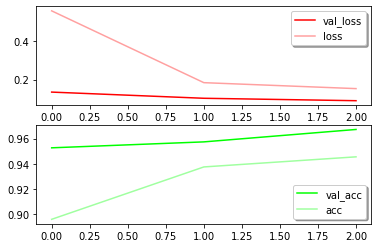

In [87]:
#start_hidden

def bloco():
    
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['val_loss'], color='#FF0000', label="val_loss")
    ax[0].plot(history.history['loss'], color='#FFA0A0', label="loss")
    legend = ax[0].legend(loc='best', shadow=True)
    
    ax[1].plot(history.history['val_acc'], color='#00FF00', label="val_acc")
    ax[1].plot(history.history['acc'], color='#A0FFA0', label="acc")
    legend = ax[1].legend(loc='best', shadow=True)          
    
bloco()

## Resultados Alcançados

O histórico abaixo apresenta as variáveis de acompanhamento calculadas com base no conjunto de dados separado para testes. 

In [88]:
def bloco():

    model.evaluate(X_test, y_test, batch_size=128)

bloco()

446/446 [==============================] - 2s 5ms/step - loss: 0.0698 - positivo_correto: 92.0000 - positivo_incorreto: 815.0000 - negativo_correto: 56049.0000 - negativo_incorreto: 6.0000 - acc: 0.9856 - precision: 0.1014 - recall: 0.9388 - auc: 0.9826 - prc: 0.7245


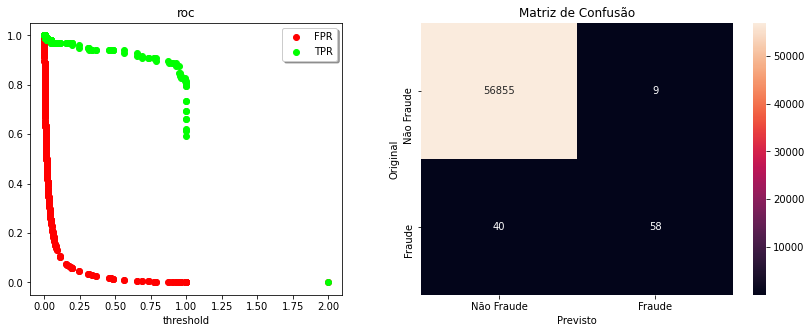

In [89]:
#start_hidden
def bloco():
    class_names=['Não Fraude','Fraude']
    
    #test_loss, test_acc = model.evaluate(X_test, y_test)

    # Predict the values from the validation dataset
    y_pred = model.predict(X_test)
    y_pred = y_pred.flatten()
        
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    fig = plt.figure(figsize=(14,5))
    fig_grid = fig.add_gridspec(100,300)

    ax1 = fig.add_subplot( fig_grid[ 0:100, 0:120 ] )   
    ax1.set( title='roc', xlabel='threshold')
    fig_hist = ax1.scatter( y=fpr, x=thresholds, color='#FF0000', label='FPR' )
    fig_hist = ax1.scatter( y=tpr, x=thresholds, color='#00FF00', label='TPR' )
    legend = ax1.legend(loc='best', shadow=True)
   
    confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
    
    ax2 = fig.add_subplot( fig_grid[ 0:100, 150:300 ] )
    ax2.set( title='Matriz de Confusão' )
    c = sns.heatmap(confusion_mtx, annot=True, fmt='g', ax=ax2)
    c.set(xticklabels=class_names, yticklabels=class_names)
    c.set(xlabel='Previsto',ylabel='Original')

    plt.show()
    
bloco()

Os resultados alcançados foram bons. O modelo identificou 70 das 98 transações fraudulentas na base de teste que corresponde a um positivo verdadeiro de 71% e alertou apenas 7 transações incorretas que representa um falso positivo de apenas 9% (ou um acerto de 91% sobre o alertado).

Lógico que 28 casos passariam, mas o próximo passso seria extrair os falsos negativos e tentar gerar outro modelo para identifica-los. 

### a